# CarbonWatch: Carbon Transaction Classification Model

This notebook implements a machine learning pipeline for classifying carbon credit transactions using TensorFlow/Keras. The model classifies transactions into three categories:
- **Verified**: Legitimate carbon credit transactions
- **Caution**: Transactions requiring review
- **High-Risk**: Potentially fraudulent transactions

## Pipeline Overview
1. Data loading and cleaning
2. Feature preprocessing and encoding
3. Neural network model building
4. Model training with early stopping
5. Model evaluation and saving

## 1. Import Libraries and Set Up Environment

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import os

# Menonaktifkan log TensorFlow yang kurang relevan
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print("TensorFlow Version:", tf.__version__)

2025-08-15 15:50:10.200250: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755247810.217787  187673 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755247810.222729  187673 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-15 15:50:10.242509: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow Version: 2.18.1


## 2. Load and Clean Data

Define function to load the dataset from CSV file and handle missing values through imputation.

In [2]:
def load_and_clean_data(filepath):
    """
    Memuat dataset dari filepath, membersihkan data, dan menanganani nilai yang hilang.
    """
    print("\n--- Memulai Pemuatan dan Pembersihan Data ---")
    df = pd.read_csv(filepath)

    # Mengatasi inkonsistensi data (contoh: 'PT.' menjadi 'PT')
    if 'Entity Type' in df.columns:
        df['Entity Type'] = df['Entity Type'].str.replace('.', '', regex=False)

    # Imputasi untuk nilai numerik yang hilang (NaN) dengan median
    numeric_cols = df.select_dtypes(include=np.number).columns
    imputer_numeric = SimpleImputer(strategy='median')
    df[numeric_cols] = imputer_numeric.fit_transform(df[numeric_cols])
    print("Nilai numerik yang hilang telah diisi dengan median.")

    # Imputasi untuk nilai kategorikal yang hilang (NaN) dengan modus
    categorical_cols = df.select_dtypes(include='object').columns.drop('Label')
    imputer_categorical = SimpleImputer(strategy='most_frequent')
    df[categorical_cols] = imputer_categorical.fit_transform(df[categorical_cols])
    print("Nilai kategorikal yang hilang telah diisi dengan modus.")
    
    print("--- Pembersihan Data Selesai ---")
    return df

In [3]:
# Load and clean the dataset
dataset_path = 'dummy.csv'
if not os.path.exists(dataset_path):
    print(f"Error: File '{dataset_path}' tidak ditemukan. Pastikan file tersebut ada di direktori yang sama.")
else:
    cleaned_df = load_and_clean_data(dataset_path)
    print(f"Dataset loaded with shape: {cleaned_df.shape}")
    print(f"Columns: {list(cleaned_df.columns)}")
    print(f"Label distribution:\n{cleaned_df['Label'].value_counts()}")


--- Memulai Pemuatan dan Pembersihan Data ---
Nilai numerik yang hilang telah diisi dengan median.
Nilai kategorikal yang hilang telah diisi dengan modus.
--- Pembersihan Data Selesai ---
Dataset loaded with shape: (1000, 12)
Columns: ['Transaction Amount', 'Carbon Volume', 'Price per Ton', 'Origin Country', 'Cross-Border Flag', 'Buyer Industry', 'Sudden Transaction Spike', 'Transaction Hour', 'Entity Type', 'Label', 'company id', 'nama perusahaan']
Label distribution:
Label
Verified     700
Caution      200
High-Risk    100
Name: count, dtype: int64


## 3. Preprocess Data

Separate features and labels, encode target labels, and set up preprocessing transformers for numerical and categorical features.

In [4]:
def preprocess_data(df):
    """
    Memisahkan fitur dan label, melakukan encoding dan scaling.
    """
    print("\n--- Memulai Pra-pemrosesan Data ---")
    # Memilih fitur (X) dari daftar kolom yang diinginkan dan label (y)
    feature_cols = [
        'Transaction Amount', 'Carbon Volume', 'Price per Ton', 'Origin Country',
        'Cross-Border Flag', 'Buyer Industry', 'Sudden Transaction Spike',
        'Transaction Hour', 'Entity Type'
    ]
    # Periksa apakah semua kolom fitur ada di dataframe
    missing_cols = [c for c in feature_cols if c not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing expected feature columns: {missing_cols}")
    X = df[feature_cols]
    y = df['Label']

    # Encoding label target (Verified, Caution, High-Risk -> 0, 1, 2)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    # Mengubah ke format one-hot untuk TensorFlow
    y_categorical = tf.keras.utils.to_categorical(y_encoded)
    
    # Menyiapkan transformer untuk kolom numerik dan kategorikal
    numeric_features = X.select_dtypes(include=np.number).columns
    categorical_features = X.select_dtypes(include=['object', 'bool']).columns

    preprocessor = make_column_transformer(
        (StandardScaler(), numeric_features),
        (OneHotEncoder(handle_unknown='ignore'), categorical_features)
    )
    
    print("Fitur numerik akan di-scale, fitur kategorikal akan di-encode.")
    print("--- Pra-pemrosesan Selesai ---")
    return X, y_categorical, preprocessor, label_encoder

In [5]:
# Apply preprocessing
X, y, preprocessor, le = preprocess_data(cleaned_df)
print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Label classes: {le.classes_}")


--- Memulai Pra-pemrosesan Data ---
Fitur numerik akan di-scale, fitur kategorikal akan di-encode.
--- Pra-pemrosesan Selesai ---
Features shape: (1000, 9)
Labels shape: (1000, 3)
Label classes: ['Caution' 'High-Risk' 'Verified']


## 4. Split Data into Training and Testing Sets

Use stratified train-test split to ensure balanced representation of each class in both training and testing sets.

In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set - Features: {X_train.shape}, Labels: {y_train.shape}")
print(f"Testing set - Features: {X_test.shape}, Labels: {y_test.shape}")
print(f"Training labels distribution:\n{pd.Series(y_train.argmax(axis=1)).value_counts()}")
print(f"Testing labels distribution:\n{pd.Series(y_test.argmax(axis=1)).value_counts()}")

Training set - Features: (800, 9), Labels: (800, 3)
Testing set - Features: (200, 9), Labels: (200, 3)
Training labels distribution:
2    560
0    160
1     80
Name: count, dtype: int64
Testing labels distribution:
2    140
0     40
1     20
Name: count, dtype: int64


## 5. Apply Preprocessing to Data

Fit the preprocessor on training data and transform both training and testing sets to prepare them for the neural network.

In [7]:
# Apply preprocessing transformations
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed training features shape: {X_train_processed.shape}")
print(f"Processed testing features shape: {X_test_processed.shape}")
print(f"Input dimension for neural network: {X_train_processed.shape[1]}")

Processed training features shape: (800, 34)
Processed testing features shape: (200, 34)
Input dimension for neural network: 34


## 6. Build Neural Network Model

Create a Sequential Keras model with dense layers, dropout for regularization, and softmax output for multi-class classification.

In [8]:
def build_model(input_shape):
    """
    Membangun arsitektur model neural network dengan TensorFlow/Keras.
    """
    print("\n--- Membangun Model Jaringan Saraf Tiruan ---")
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_shape,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax') # 3 kelas output (Verified, Caution, High-Risk)
    ])

    # Mengompilasi model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.summary()
    return model

In [9]:
# Build the model
input_dim = X_train_processed.shape[1]
model = build_model(input_dim)


--- Membangun Model Jaringan Saraf Tiruan ---


I0000 00:00:1755247814.214277  187673 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5660 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:10:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,915 (58.26 KB)

 Trainable params: 14,915 (58.26 KB)

 Non-trainable params: 0 (0.00 B)

## 7. Train Model

Train the neural network using the training data with early stopping callback to prevent overfitting.

In [10]:
# Set up early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
print("\n--- Memulai Pelatihan Model ---")
history = model.fit(
    X_train_processed, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)
print("--- Pelatihan Model Selesai ---")


--- Memulai Pelatihan Model ---
Epoch 1/100


I0000 00:00:1755247815.843050  187783 service.cc:148] XLA service 0x7f3c4000ae60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755247815.843088  187783 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2025-08-15 15:50:15.867454: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755247816.004993  187783 cuda_dnn.cc:529] Loaded cuDNN version 90300


16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3751 - loss: 1.0892

I0000 00:00:1755247817.185442  187783 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.4284 - loss: 1.0599 - val_accuracy: 0.7812 - val_loss: 0.7027
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7747 - loss: 0.6421 - val_accuracy: 0.7875 - val_loss: 0.4017
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8058 - loss: 0.4292 - val_accuracy: 0.8938 - val_loss: 0.2716
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8899 - loss: 0.2868 - val_accuracy: 0.9625 - val_loss: 0.1542
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9475 - loss: 0.1751 - val_accuracy: 0.9812 - val_loss: 0.0707
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9842 - loss: 0.0876 - val_accuracy: 1.0000 - val_loss: 0.0369
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9870 - loss: 0.0573 - val_accuracy: 1.0000 - val_loss: 0.0204
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9809 - loss: 0.0602 - val_accuracy: 1.0000 - val_loss: 0.

## 8. Evaluate Model

Evaluate the trained model on the test set to measure its performance on unseen data.

In [11]:
# Evaluate the model on test data
print("\n--- Mengevaluasi Model pada Data Test ---")
loss, accuracy = model.evaluate(X_test_processed, y_test)
print(f"Akurasi Model: {accuracy * 100:.2f}%")
print(f"Loss Model: {loss:.4f}")

# Make predictions on test set
predictions = model.predict(X_test_processed)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Display some sample predictions
print(f"\nBeberapa contoh prediksi:")
for i in range(5):
    true_label = le.classes_[true_classes[i]]
    pred_label = le.classes_[predicted_classes[i]]
    confidence = np.max(predictions[i]) * 100
    print(f"Sample {i+1}: True={true_label}, Predicted={pred_label}, Confidence={confidence:.1f}%")


--- Mengevaluasi Model pada Data Test ---
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.9815 - loss: 0.0587
Akurasi Model: 98.50%
Loss Model: 0.0549
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

Beberapa contoh prediksi:
Sample 1: True=Verified, Predicted=Verified, Confidence=100.0%
Sample 2: True=High-Risk, Predicted=High-Risk, Confidence=100.0%
Sample 3: True=Caution, Predicted=Caution, Confidence=100.0%
Sample 4: True=Caution, Predicted=Caution, Confidence=99.8%
Sample 5: True=Verified, Predicted=Verified, Confidence=100.0%


## 8.1. Model Performance Visualization

Visualize training history, confusion matrix, and other metrics to analyze model performance and detect overfitting.

In [12]:
# Import additional libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Set plot style
plt.style.use('default')
sns.set_palette("husl")

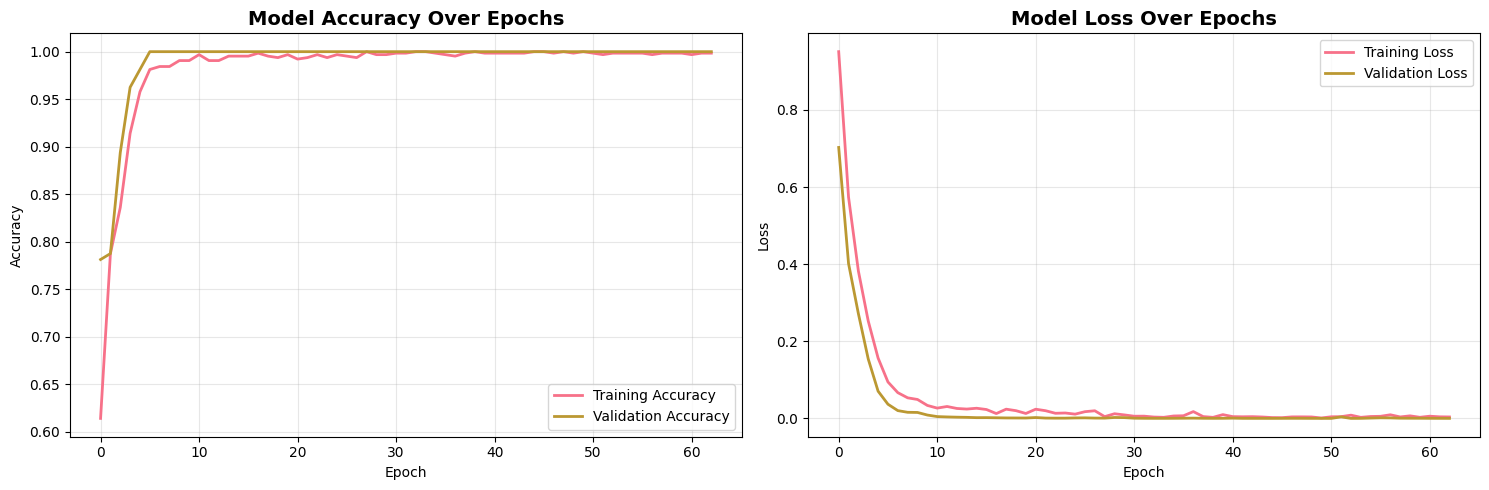


📊 Analisis Overfitting:
Training Accuracy: 0.9984
Validation Accuracy: 1.0000
Training Loss: 0.0039
Validation Loss: 0.0003
✅ Model terlihat tidak overfitting.


In [13]:
# Plot training history to check for overfitting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot training & validation loss
ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze overfitting
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📊 Analisis Overfitting:")
print(f"Training Accuracy: {final_train_acc:.4f}")
print(f"Validation Accuracy: {final_val_acc:.4f}")
print(f"Training Loss: {final_train_loss:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")

acc_diff = abs(final_train_acc - final_val_acc)
loss_diff = abs(final_val_loss - final_train_loss)

if acc_diff > 0.05 or loss_diff > 0.1:
    print("⚠️  Model menunjukkan tanda-tanda overfitting!")
else:
    print("✅ Model terlihat tidak overfitting.")

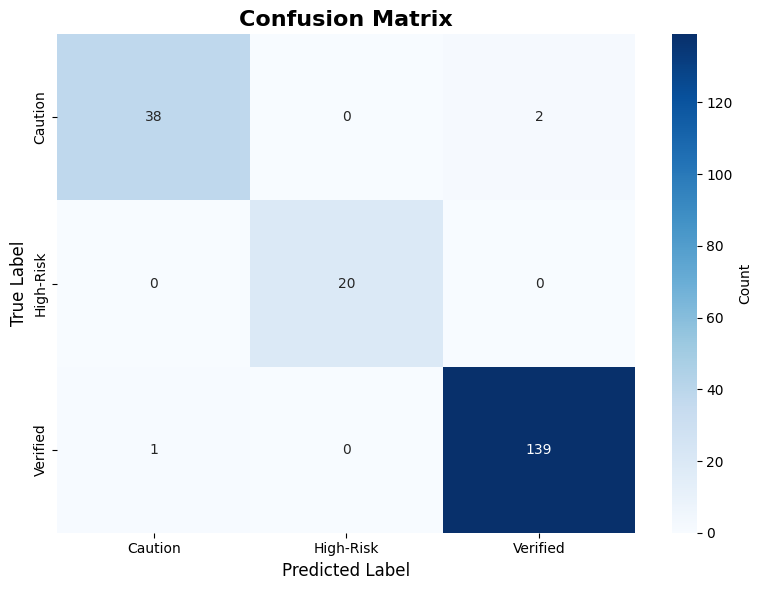


📋 Classification Report:
              precision    recall  f1-score   support

     Caution       0.97      0.95      0.96        40
   High-Risk       1.00      1.00      1.00        20
    Verified       0.99      0.99      0.99       140

    accuracy                           0.98       200
   macro avg       0.99      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200


📈 Weighted Average Metrics:
Precision: 0.9849
Recall: 0.9850
F1-Score: 0.9849


In [14]:
# Create and visualize confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate per-class metrics
print("\n📋 Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=le.classes_))

# Calculate additional metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"\n📈 Weighted Average Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

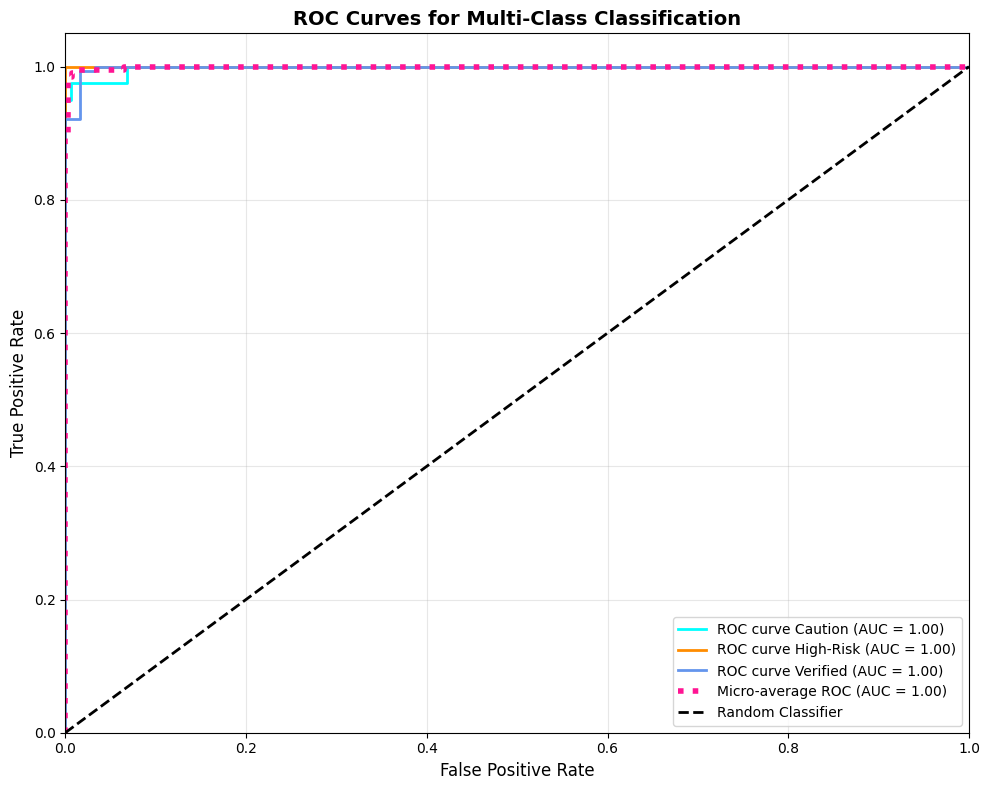


🎯 AUC Scores per Class:
Caution: 0.9981
High-Risk: 1.0000
Verified: 0.9986
Micro-average: 0.9994


In [15]:
# ROC Curve for multi-class classification
# Binarize the output for ROC calculation
y_test_bin = label_binarize(true_classes, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for Multi-Class Classification', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n🎯 AUC Scores per Class:")
for i, class_name in enumerate(le.classes_):
    print(f"{class_name}: {roc_auc[i]:.4f}")
print(f"Micro-average: {roc_auc['micro']:.4f}")

/tmp/ipykernel_187673/434495543.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([confidence_by_class[class_name] for class_name in le.classes_],


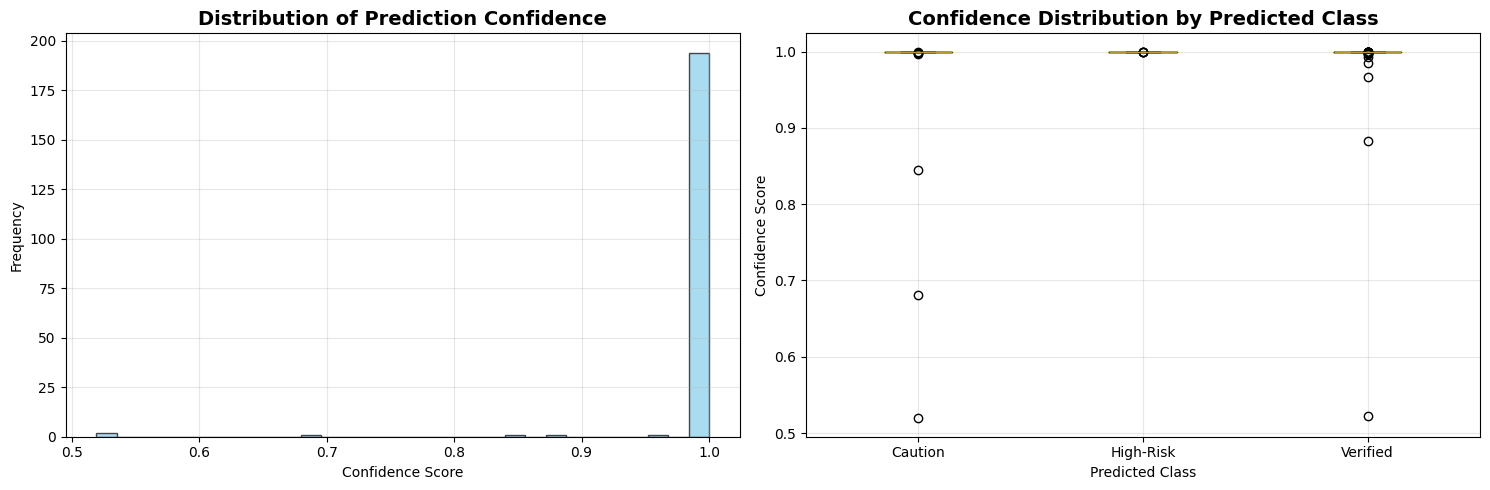


🎯 Confidence Statistics:
Mean Confidence: 0.9919
Median Confidence: 1.0000
Min Confidence: 0.5192
Max Confidence: 1.0000

⚠️  Predictions with low confidence (<0.6):
Count: 2 out of 200 (1.0%)
Classes with low confidence predictions:
  Caution: 1 predictions
  Verified: 1 predictions


In [16]:
# Analyze prediction confidence distribution
confidence_scores = np.max(predictions, axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Overall confidence distribution
ax1.hist(confidence_scores, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_title('Distribution of Prediction Confidence', fontsize=14, fontweight='bold')
ax1.set_xlabel('Confidence Score')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)

# Confidence by class
confidence_by_class = {}
for i, class_name in enumerate(le.classes_):
    class_mask = predicted_classes == i
    confidence_by_class[class_name] = confidence_scores[class_mask]

ax2.boxplot([confidence_by_class[class_name] for class_name in le.classes_], 
           labels=le.classes_)
ax2.set_title('Confidence Distribution by Predicted Class', fontsize=14, fontweight='bold')
ax2.set_xlabel('Predicted Class')
ax2.set_ylabel('Confidence Score')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print confidence statistics
print(f"\n🎯 Confidence Statistics:")
print(f"Mean Confidence: {np.mean(confidence_scores):.4f}")
print(f"Median Confidence: {np.median(confidence_scores):.4f}")
print(f"Min Confidence: {np.min(confidence_scores):.4f}")
print(f"Max Confidence: {np.max(confidence_scores):.4f}")

# Low confidence predictions (potential uncertain cases)
low_confidence_threshold = 0.6
low_conf_mask = confidence_scores < low_confidence_threshold
num_low_conf = np.sum(low_conf_mask)

print(f"\n⚠️  Predictions with low confidence (<{low_confidence_threshold}):")
print(f"Count: {num_low_conf} out of {len(confidence_scores)} ({num_low_conf/len(confidence_scores)*100:.1f}%)")

if num_low_conf > 0:
    print(f"Classes with low confidence predictions:")
    low_conf_classes = predicted_classes[low_conf_mask]
    for class_idx in np.unique(low_conf_classes):
        count = np.sum(low_conf_classes == class_idx)
        print(f"  {le.classes_[class_idx]}: {count} predictions")

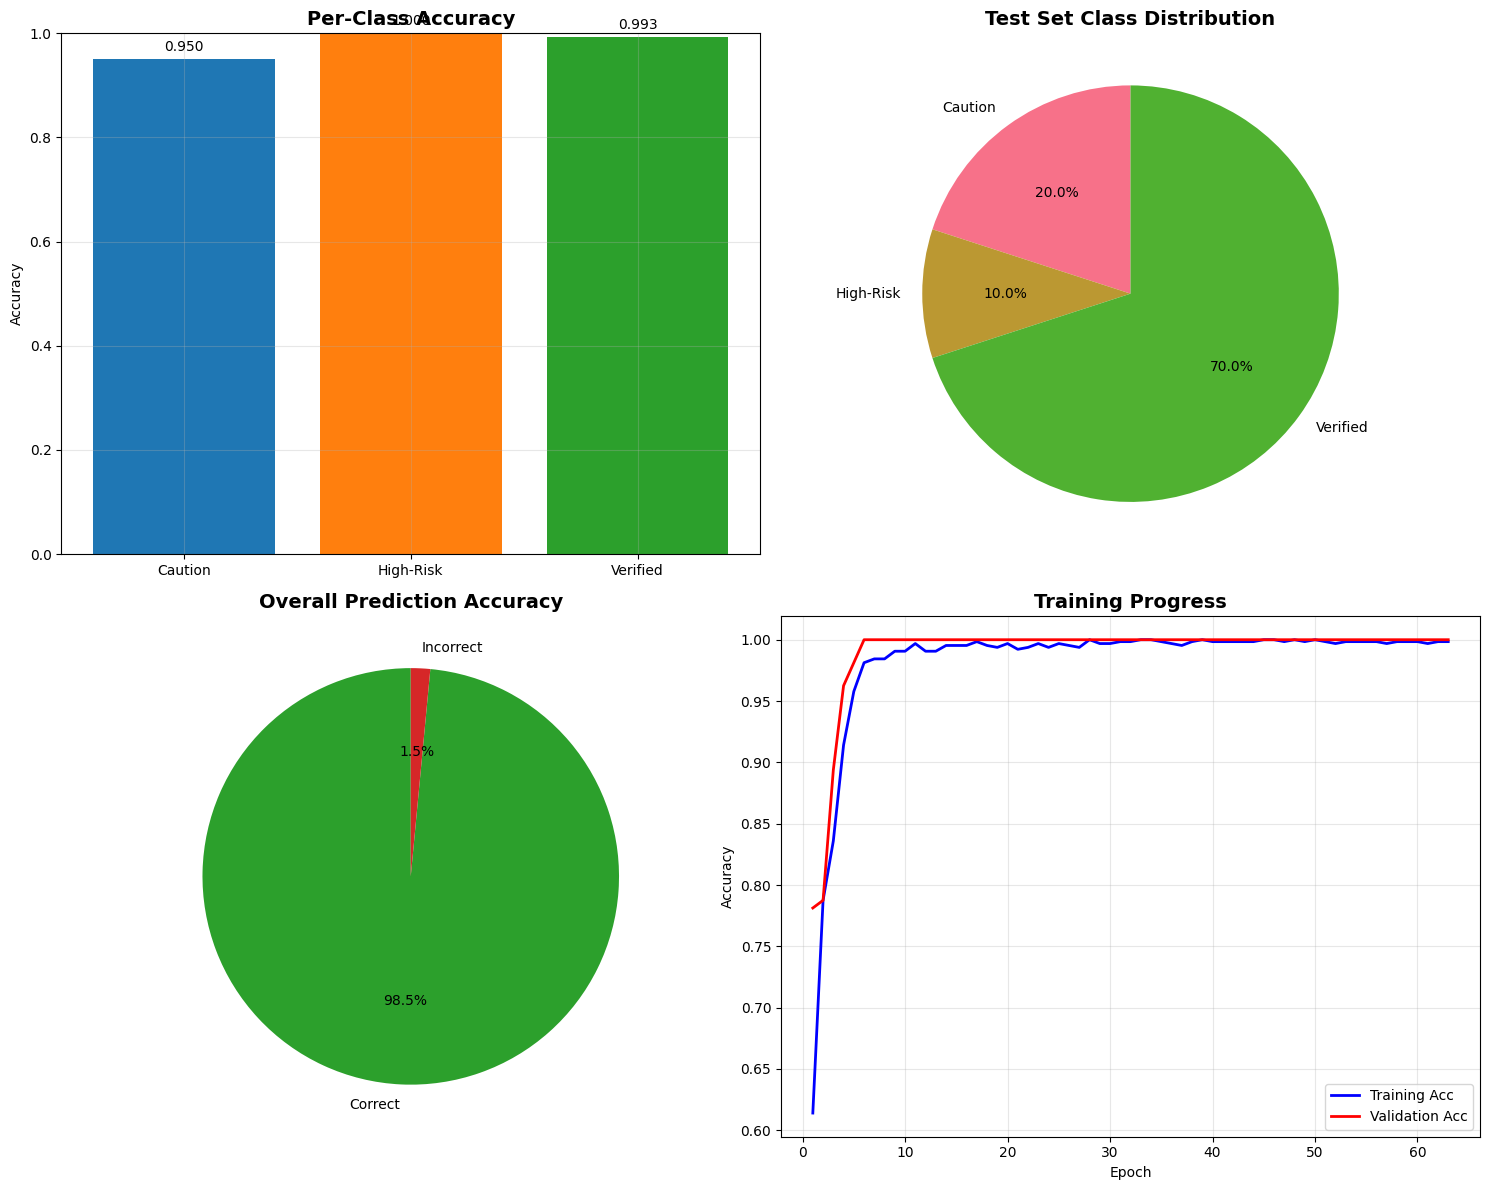

📊 MODEL PERFORMANCE SUMMARY
Overall Test Accuracy: 0.9850 (98.50%)
Overall Test Loss: 0.0549
Total Test Samples: 200
Training Epochs: 63

Per-Class Performance:
  Caution: 0.9500 (95.00%)
  High-Risk: 1.0000 (100.00%)
  Verified: 0.9929 (99.29%)

Model Confidence:
  Average Confidence: 0.9919
  Low Confidence Predictions: 2/200 (1.0%)


In [17]:
# Model Performance Summary
def create_performance_summary():
    """Create a comprehensive performance summary"""
    
    # Calculate per-class accuracy
    per_class_acc = {}
    for i, class_name in enumerate(le.classes_):
        mask = true_classes == i
        if np.sum(mask) > 0:
            correct = np.sum((true_classes == i) & (predicted_classes == i))
            total = np.sum(mask)
            per_class_acc[class_name] = correct / total
    
    # Create summary visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Per-class accuracy
    classes = list(per_class_acc.keys())
    accuracies = list(per_class_acc.values())
    bars1 = ax1.bar(classes, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax1.set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1)
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')
    ax1.grid(True, alpha=0.3)
    
    # 2. Class distribution in test set
    unique, counts = np.unique(true_classes, return_counts=True)
    class_names = [le.classes_[i] for i in unique]
    ax2.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')
    
    # 3. Correct vs Incorrect predictions
    correct_mask = true_classes == predicted_classes
    correct_count = np.sum(correct_mask)
    incorrect_count = len(true_classes) - correct_count
    
    ax3.pie([correct_count, incorrect_count], 
           labels=['Correct', 'Incorrect'], 
           colors=['#2ca02c', '#d62728'],
           autopct='%1.1f%%', startangle=90)
    ax3.set_title('Overall Prediction Accuracy', fontsize=14, fontweight='bold')
    
    # 4. Training epochs vs performance
    epochs = range(1, len(history.history['accuracy']) + 1)
    ax4.plot(epochs, history.history['accuracy'], 'b-', label='Training Acc', linewidth=2)
    ax4.plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Acc', linewidth=2)
    ax4.set_title('Training Progress', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("="*60)
    print("📊 MODEL PERFORMANCE SUMMARY")
    print("="*60)
    print(f"Overall Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Overall Test Loss: {loss:.4f}")
    print(f"Total Test Samples: {len(y_test)}")
    print(f"Training Epochs: {len(history.history['accuracy'])}")
    print("\nPer-Class Performance:")
    for class_name, acc in per_class_acc.items():
        print(f"  {class_name}: {acc:.4f} ({acc*100:.2f}%)")
    
    print(f"\nModel Confidence:")
    print(f"  Average Confidence: {np.mean(confidence_scores):.4f}")
    print(f"  Low Confidence Predictions: {num_low_conf}/{len(confidence_scores)} ({num_low_conf/len(confidence_scores)*100:.1f}%)")

create_performance_summary()

## 9. Save Trained Model

Save the trained model to disk for future use and deployment.

In [18]:
# Save the trained model
model_filename = 'carbon_watch_model.keras'
model.save(model_filename)
print(f"\n--- Model telah berhasil disimpan sebagai '{model_filename}' ---")

# Also save the preprocessor and label encoder for future use
import pickle

with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("Preprocessor dan Label Encoder juga telah disimpan untuk penggunaan masa depan.")


--- Model telah berhasil disimpan sebagai 'carbon_watch_model.keras' ---
Preprocessor dan Label Encoder juga telah disimpan untuk penggunaan masa depan.


## Conclusion

The CarbonWatch model has been successfully trained and evaluated. The pipeline includes:

1. ✅ **Data Loading & Cleaning**: Handled missing values and data inconsistencies
2. ✅ **Feature Preprocessing**: Applied scaling to numerical features and encoding to categorical features  
3. ✅ **Model Architecture**: Built a neural network with dropout layers for regularization
4. ✅ **Training**: Used early stopping to prevent overfitting
5. ✅ **Evaluation**: Assessed model performance on test data
6. ✅ **Model Persistence**: Saved the trained model, preprocessor, and label encoder

The model is now ready to classify carbon credit transactions into three categories:
- **Verified**: Legitimate transactions
- **Caution**: Transactions requiring review
- **High-Risk**: Potentially fraudulent transactions

### Next Steps
- Deploy the model for real-time transaction monitoring
- Implement model monitoring and retraining procedures
- Add additional features or ensemble methods to improve performance